In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
pip install efficientnet_pytorch

In [38]:
pip install albumentations

In [39]:
import torchvision, time, os, copy
import torch.nn as nn
import torch.optim as optim
import torch, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import cv2 as cv
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, auc, roc_curve
from sklearn.metrics import log_loss
from tqdm import tqdm_notebook as tqdm
from efficientnet_pytorch import EfficientNet

import albumentations
from albumentations import torch as albumentations_torch
from albumentations import (ToFloat, 
    CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, RandomBrightnessContrast,
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, Resize,
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, OneOf, Compose, HorizontalFlip, PadIfNeeded, ToGray
)

In [40]:
print(torch.__version__)

1.7.0+cu101


In [41]:
TRAINING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Training_Images'
TESTING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Testing_Images'
REAL_FOLDER = 'REAL'
FAKE_FOLDER = 'FAKE'

train_list_real = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, REAL_FOLDER)))
train_list_fake = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, FAKE_FOLDER)))

In [42]:

data_transforms = Compose([
        GaussNoise(p=0.1),
        HorizontalFlip(),
        PadIfNeeded(min_height=200, min_width=200, border_mode=cv.BORDER_CONSTANT),
        OneOf([RandomBrightnessContrast(), HueSaturationValue()], p=0.7),
        ToGray(p=0.2),
        #ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv.BORDER_CONSTANT, p=0.5),
        Resize(256, 256), #B7 Resize(600,600)
        albumentations_torch.ToTensor()
    ])

data_transforms_test = Compose([
        Resize(256, 256), #B7 Resize(600,600)
        albumentations_torch.ToTensor()
    ])

In [43]:
class DFDCDataset(torchvision.datasets.ImageFolder):
  def __init__(self, root, transform):
    super(DFDCDataset, self).__init__(root, transform)

  def __getitem__(self, index):
    # override ImageFolder's method
    path, target = self.samples[index]
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    if self.transform is not None:
      sample = self.transform(image=img)
    if self.target_transform is not None:
      target = self.target_transform(target)

    return sample, target

In [44]:
batch_size = 8
train_image_datasets = DFDCDataset(TRAINING_DATA_FOLDER, data_transforms)
test_image_datasets = DFDCDataset(TESTING_DATA_FOLDER, data_transforms_test)

# Creating data indices for training and validation splits:
dataset_size = len(train_image_datasets)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.seed(322)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_image_datasets, batch_size=batch_size,shuffle=True)
dataloaders = {'train': train_loader,'val':validation_loader}
dataset_sizes = {'train':len(train_loader.sampler),'val':len(validation_loader.sampler)}
class_names = train_image_datasets.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataset_size)
print(class_names)
print(device)

2183
['FAKE', 'REAL']
cuda:0


In [45]:
# Helper function for displaying images
def imshow(images, title=None):
    # Clip just in case
    images = np.clip(images.permute(1, 2, 0), 0, 1)
    plt.imshow(images)
    plt.pause(0.001)  # pause a bit so that plots are updated

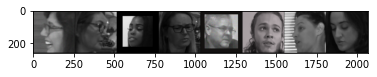

In [46]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
grid = torchvision.utils.make_grid(inputs['image'])

imshow(grid)

In [47]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_time = [] # we'll keep track of the time needed for each epoch

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),total=len(dataloaders[phase])):
                inputs = inputs['image'].to(device,dtype=torch.float)
                labels = labels.to(device,dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.unsqueeze(1))
                    preds = torch.round(torch.sigmoid(outputs))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.unsqueeze(1))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            scheduler.step()

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time

In [48]:
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=1)
for param in model.parameters():
    param.requires_grad = True

# Send the model to the GPU
model = model.to(device)
# Set the loss function
criterion = torch.nn.BCEWithLogitsLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model, epoch_time = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Loaded pretrained weights for efficientnet-b7
Epoch 1/10
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train Loss: 0.5621 Acc: 0.7081



val Loss: 0.5411 Acc: 0.7477

Epoch 2/10
----------



train Loss: 0.3994 Acc: 0.8237



val Loss: 0.3673 Acc: 0.8234

Epoch 3/10
----------



train Loss: 0.2958 Acc: 0.8758



val Loss: 0.3822 Acc: 0.8142

Epoch 4/10
----------



train Loss: 0.2412 Acc: 0.9096



val Loss: 0.2715 Acc: 0.8945

Epoch 5/10
----------



train Loss: 0.1920 Acc: 0.9302



val Loss: 0.2426 Acc: 0.8991

Epoch 6/10
----------



train Loss: 0.1554 Acc: 0.9479



val Loss: 0.2183 Acc: 0.9128

Epoch 7/10
----------



train Loss: 0.1504 Acc: 0.9502



val Loss: 0.2170 Acc: 0.9128

Epoch 8/10
----------



train Loss: 0.1135 Acc: 0.9651



val Loss: 0.2355 Acc: 0.9060

Epoch 9/10
----------



train Loss: 0.1175 Acc: 0.9611



val Loss: 0.2065 Acc: 0.9037

Epoch 10/10
----------



train Loss: 0.1175 Acc: 0.9645



val Loss: 0.2061 Acc: 0.9106

Training complete in 27m 59s
Best val Acc: 0.912844


In [49]:
predictions = []
testlabels = []
for idx, (inputs, labels) in tqdm(enumerate(test_loader),total=len(test_loader)):
  inputs = inputs['image'].to(device)
  labels = labels.to(device)
  outputs = model(inputs)
  preds = torch.round(torch.sigmoid(outputs))
  testlabels.extend(labels.cpu().detach().numpy())
  predictions.extend(preds.cpu().detach().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
f1_score(predictions, testlabels, average="macro")

0.8090909090909091